In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# ==========================================
# 設定
# ==========================================
RESULTS_DIR = "./results"       # データのルートディレクトリ
WINDOW_SIZE = 100               # 平滑化のウィンドウサイズ
MAX_INDEX = None                # 読み込む最大ステップ数（Noneの場合はあるだけ読む）
BINS = ["bin_0", "bin_1", "bin_2", "bin_3", "bin_4"] # カラム名定義

# 出力先
OUTPUT_DIR = "./results/summary"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# ==========================================
# 関数定義
# ==========================================

def smooth_list(values, window_size):
    """リストをwindow_sizeごとに平均化する"""
    smoothed = []
    # 余りが出ないように切り捨てるか、余りも含めるか。ここでは以前のノートブックに合わせて処理
    for i in range(0, len(values), window_size):
        window = values[i:i+window_size]
        if window:
            smoothed.append(sum(window) / len(window))
    return smoothed

def load_and_process_seed(seed_dir, seed_name):
    """
    1つのシード（run_?）フォルダ内の post データを読み込み、平滑化してDataFrameを返す
    """
    post_dir = os.path.join(seed_dir, "posts")
    if not os.path.exists(post_dir):
        print(f"Skipping {seed_name}: post folder not found.")
        return None

    # ファイルリストを取得してステップ数でソート
    # ファイル名パターン: post_result_123.csv
    files = glob.glob(os.path.join(post_dir, "post_result_*.csv"))
    
    # ステップ数を抽出してソートするための辞書を作成
    step_file_map = {}
    for f in files:
        match = re.search(r"post_result_(\d+)\.csv", os.path.basename(f))
        if match:
            step = int(match.group(1))
            step_file_map[step] = f
    
    sorted_steps = sorted(step_file_map.keys())
    if MAX_INDEX is not None:
        sorted_steps = [s for s in sorted_steps if s <= MAX_INDEX]

    ratios = {b: [] for b in BINS}
    counts = []
    steps = []

    # 各ステップのファイルを読み込み
    for step in sorted_steps:
        filepath = step_file_map[step]
        try:
            # ヘッダーがない場合や1行だけの場合を想定
            # ノートブックの例ではヘッダーあり: step,bin_0,...,sumOfPosts
            df_temp = pd.read_csv(filepath)
            
            if df_temp.empty:
                continue
                
            row = df_temp.iloc[0]
            
            # 投稿数を取得（sumOfPostsがあれば優先、なければbinの合計）
            if "sumOfPosts" in row:
                total_posts = int(row["sumOfPosts"])
            else:
                total_posts = sum([int(row.get(b, 0)) for b in BINS])
            
            # 投稿数が0の場合の割合は0とする（またはnan）
            current_ratios = {}
            if total_posts > 0:
                for b in BINS:
                    current_ratios[b] = int(row.get(b, 0)) / total_posts
            else:
                for b in BINS:
                    current_ratios[b] = 0.0

            # リストに追加
            for b in BINS:
                ratios[b].append(current_ratios[b])
            counts.append(total_posts)
            steps.append(step)

        except Exception as e:
            # 読み込みエラーはスキップ
            pass

    if not steps:
        return None

    # --- 平滑化処理 ---
    # ステップは代表値（区間の開始または中央）をとる
    smoothed_steps = steps[::WINDOW_SIZE]
    
    data = {"step": smoothed_steps}
    
    # 割合の平滑化
    for b in BINS:
        data[b] = smooth_list(ratios[b], WINDOW_SIZE)
        
    # 投稿数の平滑化
    data["sumOfPosts"] = smooth_list(counts, WINDOW_SIZE)
    
    # 長さが合わない場合の調整（念のため）
    min_len = min([len(v) for v in data.values()])
    for k in data.keys():
        data[k] = data[k][:min_len]

    df_seed = pd.DataFrame(data)
    df_seed["seed"] = seed_name
    return df_seed

Found 10 seed directories.
Aggregated data saved to ./results/summary


/var/folders/02/0ym8ylh51y3bbbn3ymbmr4j80000gq/T/ipykernel_83174/1162589715.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(BINS))


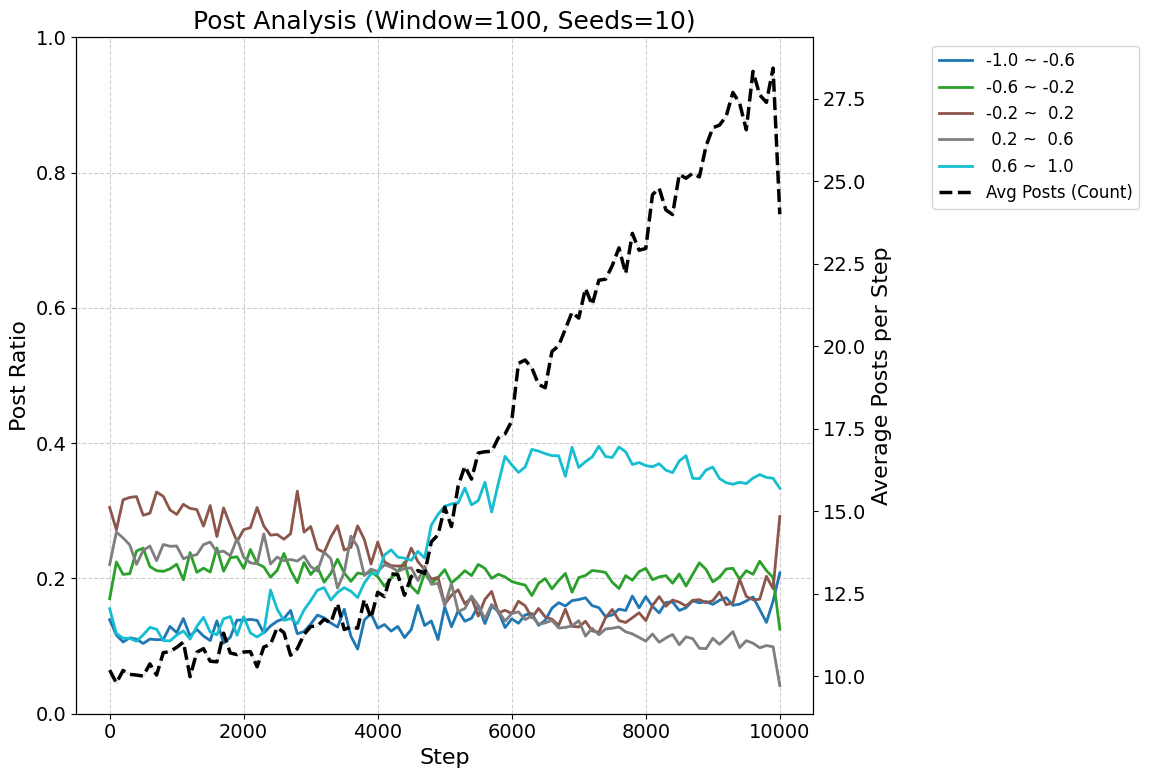

Plot generated.


In [4]:
# ==========================================
# 設定: 文字サイズなどのスタイル定義
# ==========================================
# グラフの文字サイズを全体的に大きく設定（ノートブックのスタイルに合わせる）
plt.rcParams['font.family'] = 'sans-serif'  # お好みのフォントがあれば指定
plt.rcParams['font.size'] = 14              # 基本のフォントサイズ
plt.rcParams['axes.labelsize'] = 16         # 軸ラベルのサイズ
plt.rcParams['axes.titlesize'] = 18         # タイトルのサイズ
plt.rcParams['xtick.labelsize'] = 14        # x軸目盛りのサイズ
plt.rcParams['ytick.labelsize'] = 14        # y軸目盛りのサイズ
plt.rcParams['legend.fontsize'] = 12        # 凡例のサイズ
plt.rcParams['figure.figsize'] = (12, 8)    # 画像サイズを少し大きめに

# ==========================================
# メイン処理
# ==========================================

# 1. 全シードのデータを読み込み
all_dfs = []
run_dirs = glob.glob(os.path.join(RESULTS_DIR, "run_*"))
run_dirs = sorted(run_dirs)

print(f"Found {len(run_dirs)} seed directories.")

for d in run_dirs:
    seed_name = os.path.basename(d)
    # load_and_process_seed は定義済みの関数と仮定
    df = load_and_process_seed(d, seed_name)
    if df is not None:
        all_dfs.append(df)

if not all_dfs:
    print("No valid data found.")
else:
    # 2. 全データを結合
    full_df = pd.concat(all_dfs, ignore_index=True)
    
    # 3. Stepごとに集計（数値列のみを対象に平均と標準誤差 SE を計算）
    # numeric_only=True を指定して文字列列のエラーを回避
    grouped = full_df.groupby("step")
    df_mean = grouped.mean(numeric_only=True)
    df_se = grouped.sem(numeric_only=True)

    # 結果をCSV保存（オプション）
    df_mean.to_csv(os.path.join(OUTPUT_DIR, "posts_mean_all_seeds.csv"))
    print(f"Aggregated data saved to {OUTPUT_DIR}")

    # ==========================================
    # プロット作成
    # ==========================================
    fig, ax1 = plt.subplots()

    steps = df_mean.index
    
    # BINSの定義（コード内で定義されていない場合はここで仮定）
    # もしBINS変数が外にある場合はそれを使ってください
    if 'BINS' not in locals():
        BINS = [f"bin_{i}" for i in range(5)]

    # --- ラベルのマッピング辞書を作成 ---
    # bin_0 ~ bin_4 を具体的な数値範囲に変換（必要に応じて数値を調整してください）
    bin_labels = {
        "bin_0": "-1.0 ~ -0.6",
        "bin_1": "-0.6 ~ -0.2",
        "bin_2": "-0.2 ~  0.2",
        "bin_3": " 0.2 ~  0.6",
        "bin_4": " 0.6 ~  1.0"
    }

    # カラーマップの設定
    colors = plt.cm.get_cmap("tab10", len(BINS))

    # --- 左軸: 投稿割合 (bin_0 ~ bin_4) ---
    for i, bin_name in enumerate(BINS):
        if bin_name in df_mean.columns:
            mean_val = df_mean[bin_name]
            se_val = df_se[bin_name]
            
            # ラベルを辞書から取得（なければそのままbin名）
            label_text = bin_labels.get(bin_name, bin_name)
            
            # 平均線のプロット
            ax1.plot(steps, mean_val, label=label_text, color=colors(i), linewidth=2)
            
            # 誤差範囲(SE)を塗りつぶし (帯をつける処理)
            ax1.fill_between(steps, 
                             mean_val - se_val, 
                             mean_val + se_val, 
                             color=colors(i), alpha=0.2) # alphaで透明度調整

    ax1.set_xlabel("Step")
    ax1.set_ylabel("Post Ratio")
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, linestyle="--", alpha=0.6)

    # --- 右軸: 投稿数 (sumOfPosts) ---
    # 投稿数データが存在する場合のみ描画
    if "sumOfPosts" in df_mean.columns:
        ax2 = ax1.twinx()
        
        posts_mean = df_mean["sumOfPosts"]
        posts_se = df_se["sumOfPosts"]
        
        # 投稿数は黒の点線で強調
        ax2.plot(steps, posts_mean, label="Avg Posts (Count)", color="black", linestyle="--", linewidth=2.5)
        
        # 投稿数のSE帯
        ax2.fill_between(steps, 
                         posts_mean - posts_se, 
                         posts_mean + posts_se, 
                         color="black", alpha=0.1)
        
        ax2.set_ylabel("Average Posts per Step")

        # 凡例の結合 (左軸と右軸をまとめる)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # 凡例を枠外に出す（bbox_to_anchor）
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.15, 1))
    else:
        ax1.legend(loc="upper left", bbox_to_anchor=(1.15, 1))

    plt.title(f"Post Analysis (Window={WINDOW_SIZE if 'WINDOW_SIZE' in locals() else 'N/A'}, Seeds={len(all_dfs)})")
    
    # レイアウト調整（凡例が切れないように）
    plt.tight_layout()
    
    # 画像保存
    plt.savefig(os.path.join(OUTPUT_DIR, "post_analysis_plot.png"))
    plt.show()
    
    print("Plot generated.")

In [5]:
full_df.head()

,step,bin_0,bin_1,bin_2,bin_3,bin_4,sumOfPosts,seed
0,0,0.138984,0.170139,0.304983,0.220585,0.155309,10.18,run_0
1,100,0.116354,0.224312,0.271908,0.268604,0.118822,9.79,run_0
2,200,0.106025,0.206042,0.316265,0.259946,0.111723,10.17,run_0
3,300,0.112306,0.207067,0.319805,0.249538,0.111284,10.05,run_0
4,400,0.110282,0.240624,0.321050,0.220777,0.107268,10.03,run_0
